In [7]:
# %%
# open a file as csv without header

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,natsort
import argparse

plt.rc('axes', labelsize=80)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=70)    # fontsize of the tick labels
plt.rc('ytick', labelsize=70)    # fontsize of the tick labels
plt.rc('legend', fontsize=60)    # legend fontsize

figsize = (50,25)

In [8]:
# target_dir = '/mydata/pytorch_custom_log_one_epoch_imagenet_dataset'
target_dir = '/home/mayurpl/sem_2/special_problems/ml_profiling/pace_logs/results'


In [9]:
def preprocessing_time_summary(target_dir,sort_by='batch_id',fig_size=(50,25),remove_outliers=True,fig_prefix='',fig_dir=''):
    
    root_to_files = {}
    for root, dirs, files in os.walk(target_dir):
        root_to_files[root] = files
    roots = sorted(root_to_files, key=lambda x: natsort.natsort_key(x.lower()))

    batch_to_summary= {'avg': {}, 'std': {}, 'min': {}, 'max': {}, 'median': {}, '25th': {}, '75th': {}, '75th-25th': {}}

    for root in roots:
        if 'e2e' in root:
            continue
        print(root)
        files = root_to_files[root]
        plot_df = pd.DataFrame()
        
        for file in files:
            if "worker_pid" not in file:
                continue

            df = pd.read_csv(os.path.join(root, file)
                            , header=None)

            # add header
            df.columns = ['name','start_ts','duration']

            # names that start with 'SBatchPreprocessed'
            df = df[df['name'].str.startswith('SBatchPreprocessed')]
            # map 'SBatchPreprocessed_' such that 'SBatchPreprocessed_idx' becomes 'idx' where idx is an integer
            df['batch_id'] = df['name'].map(lambda x: int(x.replace('SBatchPreprocessed_','')))


            # divide by 1000000 to convert from nanoseconds to milliseconds
            df['duration'] = df['duration']/1000000

            # concatentate all dataframes
            plot_df = pd.concat([plot_df, df])
        
        if plot_df.empty:
            continue
        def remove_wild_outliers(plot_df):
            q1 = plot_df['duration'].quantile(0.25)
            q3 = plot_df['duration'].quantile(0.75)
            iqr = (q3 - q1) * 2

            # remove outliers less than q1 - iqr only (these are numbers from last batch which has
            #  elements less than batch size because elements in a dataset may not be a multiple of batch size)
            print("remove outliers less than q1 - iqr, where iqr = (q3 - q1) * 2")
            plot_df = plot_df[~(plot_df['duration'] < (q1 - iqr))]
            return plot_df
        label = root.split('/')[-1] # retrieves b128_gpu4 kind of label
        print(f'{label}:')
        # remove outliers
        if remove_outliers:
            plot_df = remove_wild_outliers(plot_df)
          
        
        mean = np.mean(plot_df["duration"])
        std = np.std(plot_df["duration"])
        # total_preprocessing_time = np.sum(plot_df["duration"])
        quartile_diff = np.percentile(plot_df['duration'], 75) - np.percentile(plot_df['duration'], 25)

        batch_to_summary['avg'][label] = mean
        batch_to_summary['std'][label] = std
        batch_to_summary['min'][label] = plot_df["duration"].min()
        batch_to_summary['max'][label] = plot_df["duration"].max()
        batch_to_summary['median'][label] = np.median(plot_df["duration"])
        batch_to_summary['25th'][label] = np.percentile(plot_df["duration"], 25)
        batch_to_summary['75th'][label] = np.percentile(plot_df["duration"], 75)
        batch_to_summary['75th-25th'][label] = quartile_diff


    return batch_to_summary


In [10]:
batch_to_summary = preprocessing_time_summary(target_dir)

/home/mayurpl/sem_2/special_problems/ml_profiling/pace_logs/results
/home/mayurpl/sem_2/special_problems/ml_profiling/pace_logs/results/b128_gpu1
b128_gpu1:
remove outliers less than q1 - iqr, where iqr = (q3 - q1) * 2
/home/mayurpl/sem_2/special_problems/ml_profiling/pace_logs/results/b128_gpu2
b128_gpu2:
remove outliers less than q1 - iqr, where iqr = (q3 - q1) * 2
/home/mayurpl/sem_2/special_problems/ml_profiling/pace_logs/results/b128_gpu3
b128_gpu3:
remove outliers less than q1 - iqr, where iqr = (q3 - q1) * 2
/home/mayurpl/sem_2/special_problems/ml_profiling/pace_logs/results/b128_gpu4
b128_gpu4:
remove outliers less than q1 - iqr, where iqr = (q3 - q1) * 2
/home/mayurpl/sem_2/special_problems/ml_profiling/pace_logs/results/b256_gpu1
b256_gpu1:
remove outliers less than q1 - iqr, where iqr = (q3 - q1) * 2
/home/mayurpl/sem_2/special_problems/ml_profiling/pace_logs/results/b256_gpu2
b256_gpu2:
remove outliers less than q1 - iqr, where iqr = (q3 - q1) * 2
/home/mayurpl/sem_2/specia

In [11]:
# print 25th and 75th percentile
print("25th percentile:")
for k,v in batch_to_summary['25th'].items():
    print(f'{k}: {v}')
print("50th percentile:")
for k,v in batch_to_summary['median'].items():
    print(f'{k}: {v}')
print("75th percentile:")
for k,v in batch_to_summary['75th'].items():
    print(f'{k}: {v}')

25th percentile:
b128_gpu1: 2600.64217275
b128_gpu2: 2368.09978
b128_gpu3: 2271.739813
b128_gpu4: 2134.185336
b256_gpu1: 4842.668662
b256_gpu2: 4652.9312295
b256_gpu3: 4507.73055875
b256_gpu4: 4455.88680975
b512_gpu1: 9726.57900625
b512_gpu2: 9385.49325
b512_gpu3: 8982.3090675
b512_gpu4: 8379.810703
b1024_gpu1: 19309.162624
b1024_gpu2: 19091.085281
b1024_gpu3: 14113.293311000001
b1024_gpu4: 17353.416406
50th percentile:
b128_gpu1: 2791.7181435
b128_gpu2: 2552.0688920000002
b128_gpu3: 2457.571935
b128_gpu4: 2330.726046
b256_gpu1: 5180.503621
b256_gpu2: 4967.67143
b256_gpu3: 4820.931504
b256_gpu4: 4769.9401845
b512_gpu1: 10340.1936785
b512_gpu2: 9985.405148
b512_gpu3: 9530.013987999999
b512_gpu4: 9203.517476
b1024_gpu1: 20381.181962
b1024_gpu2: 20144.232593
b1024_gpu3: 17249.402166
b1024_gpu4: 18489.057541
75th percentile:
b128_gpu1: 2995.94180025
b128_gpu2: 2736.9615505
b128_gpu3: 2651.8968919999998
b128_gpu4: 2514.155794
b256_gpu1: 5526.177649
b256_gpu2: 5266.060257
b256_gpu3: 5145.605

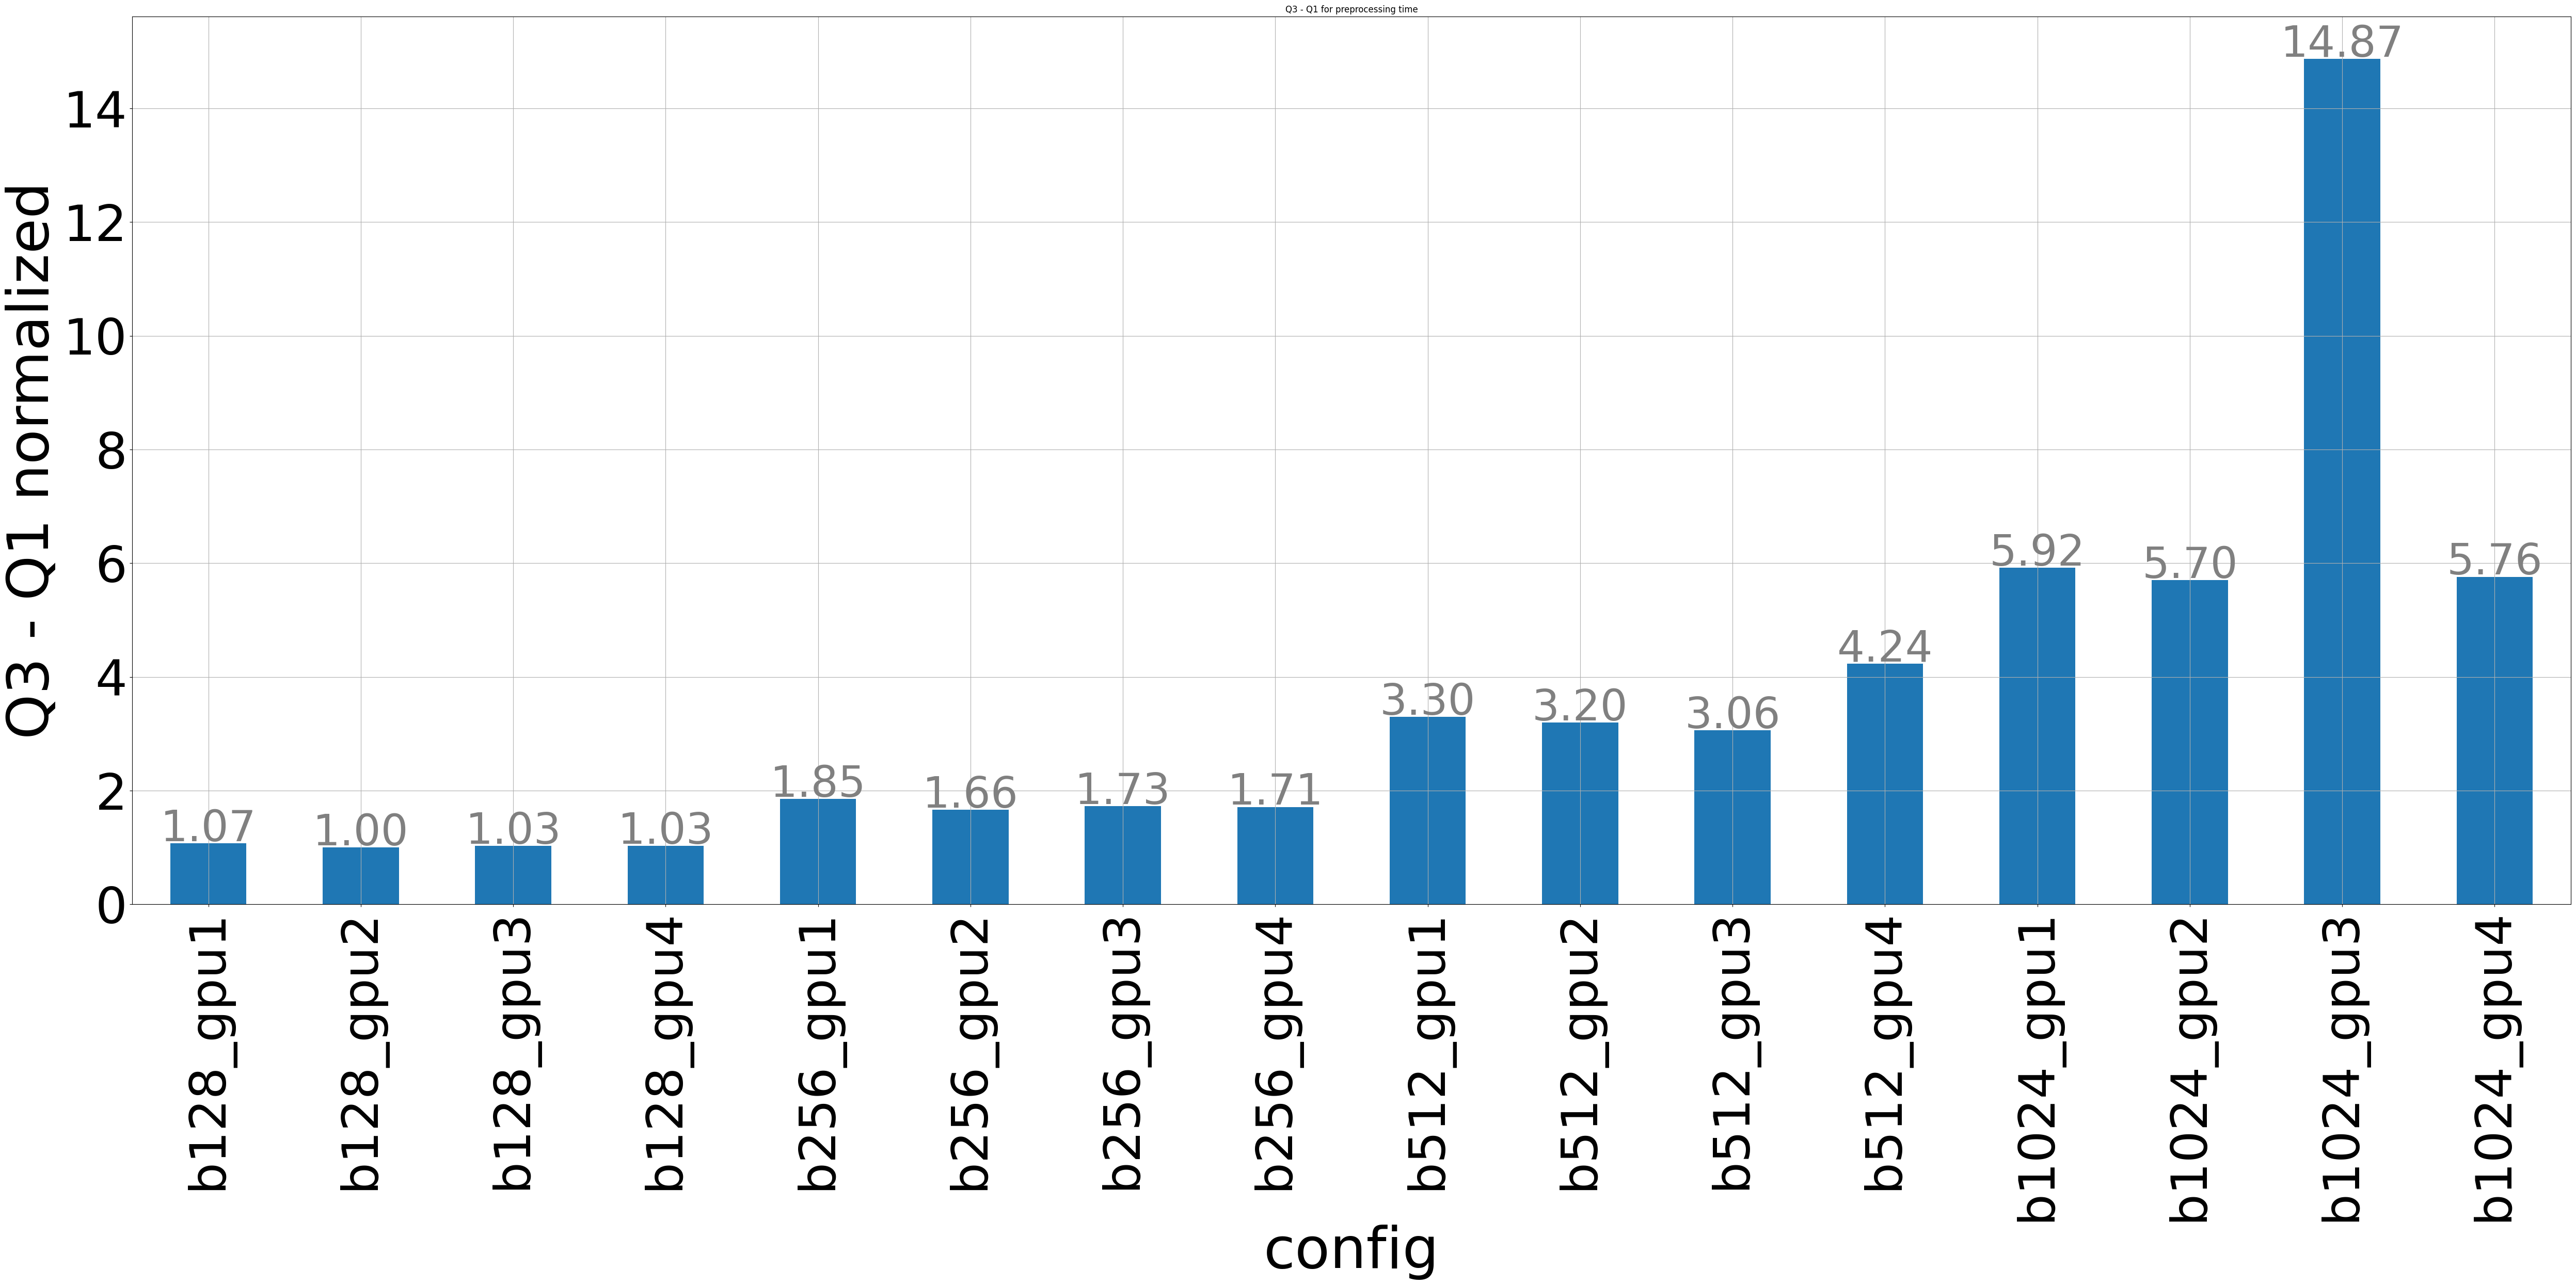

In [12]:
quartile_diff = batch_to_summary['75th-25th']
quartile_diff = pd.DataFrame.from_dict(quartile_diff, orient='index', columns=['quartile_diff'])
quartile_diff.head()
# normalize quartile_diff wrt to smallest quartile_diff
quartile_diff['quartile_diff_normalized'] = quartile_diff['quartile_diff']/quartile_diff['quartile_diff'].min()
# plot
fig, ax = plt.subplots(figsize=(50,25))
quartile_diff['quartile_diff_normalized'].plot(kind='bar', ax=ax)
# put numbers on top of bars

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=60, color='gray', xytext=(0, 20),
                textcoords='offset points')

ax.set_xlabel('config')
ax.set_ylabel('Q3 - Q1 normalized')
ax.set_title('Q3 - Q1 for preprocessing time')
ax.grid(True)
fig.tight_layout()

plt.show()

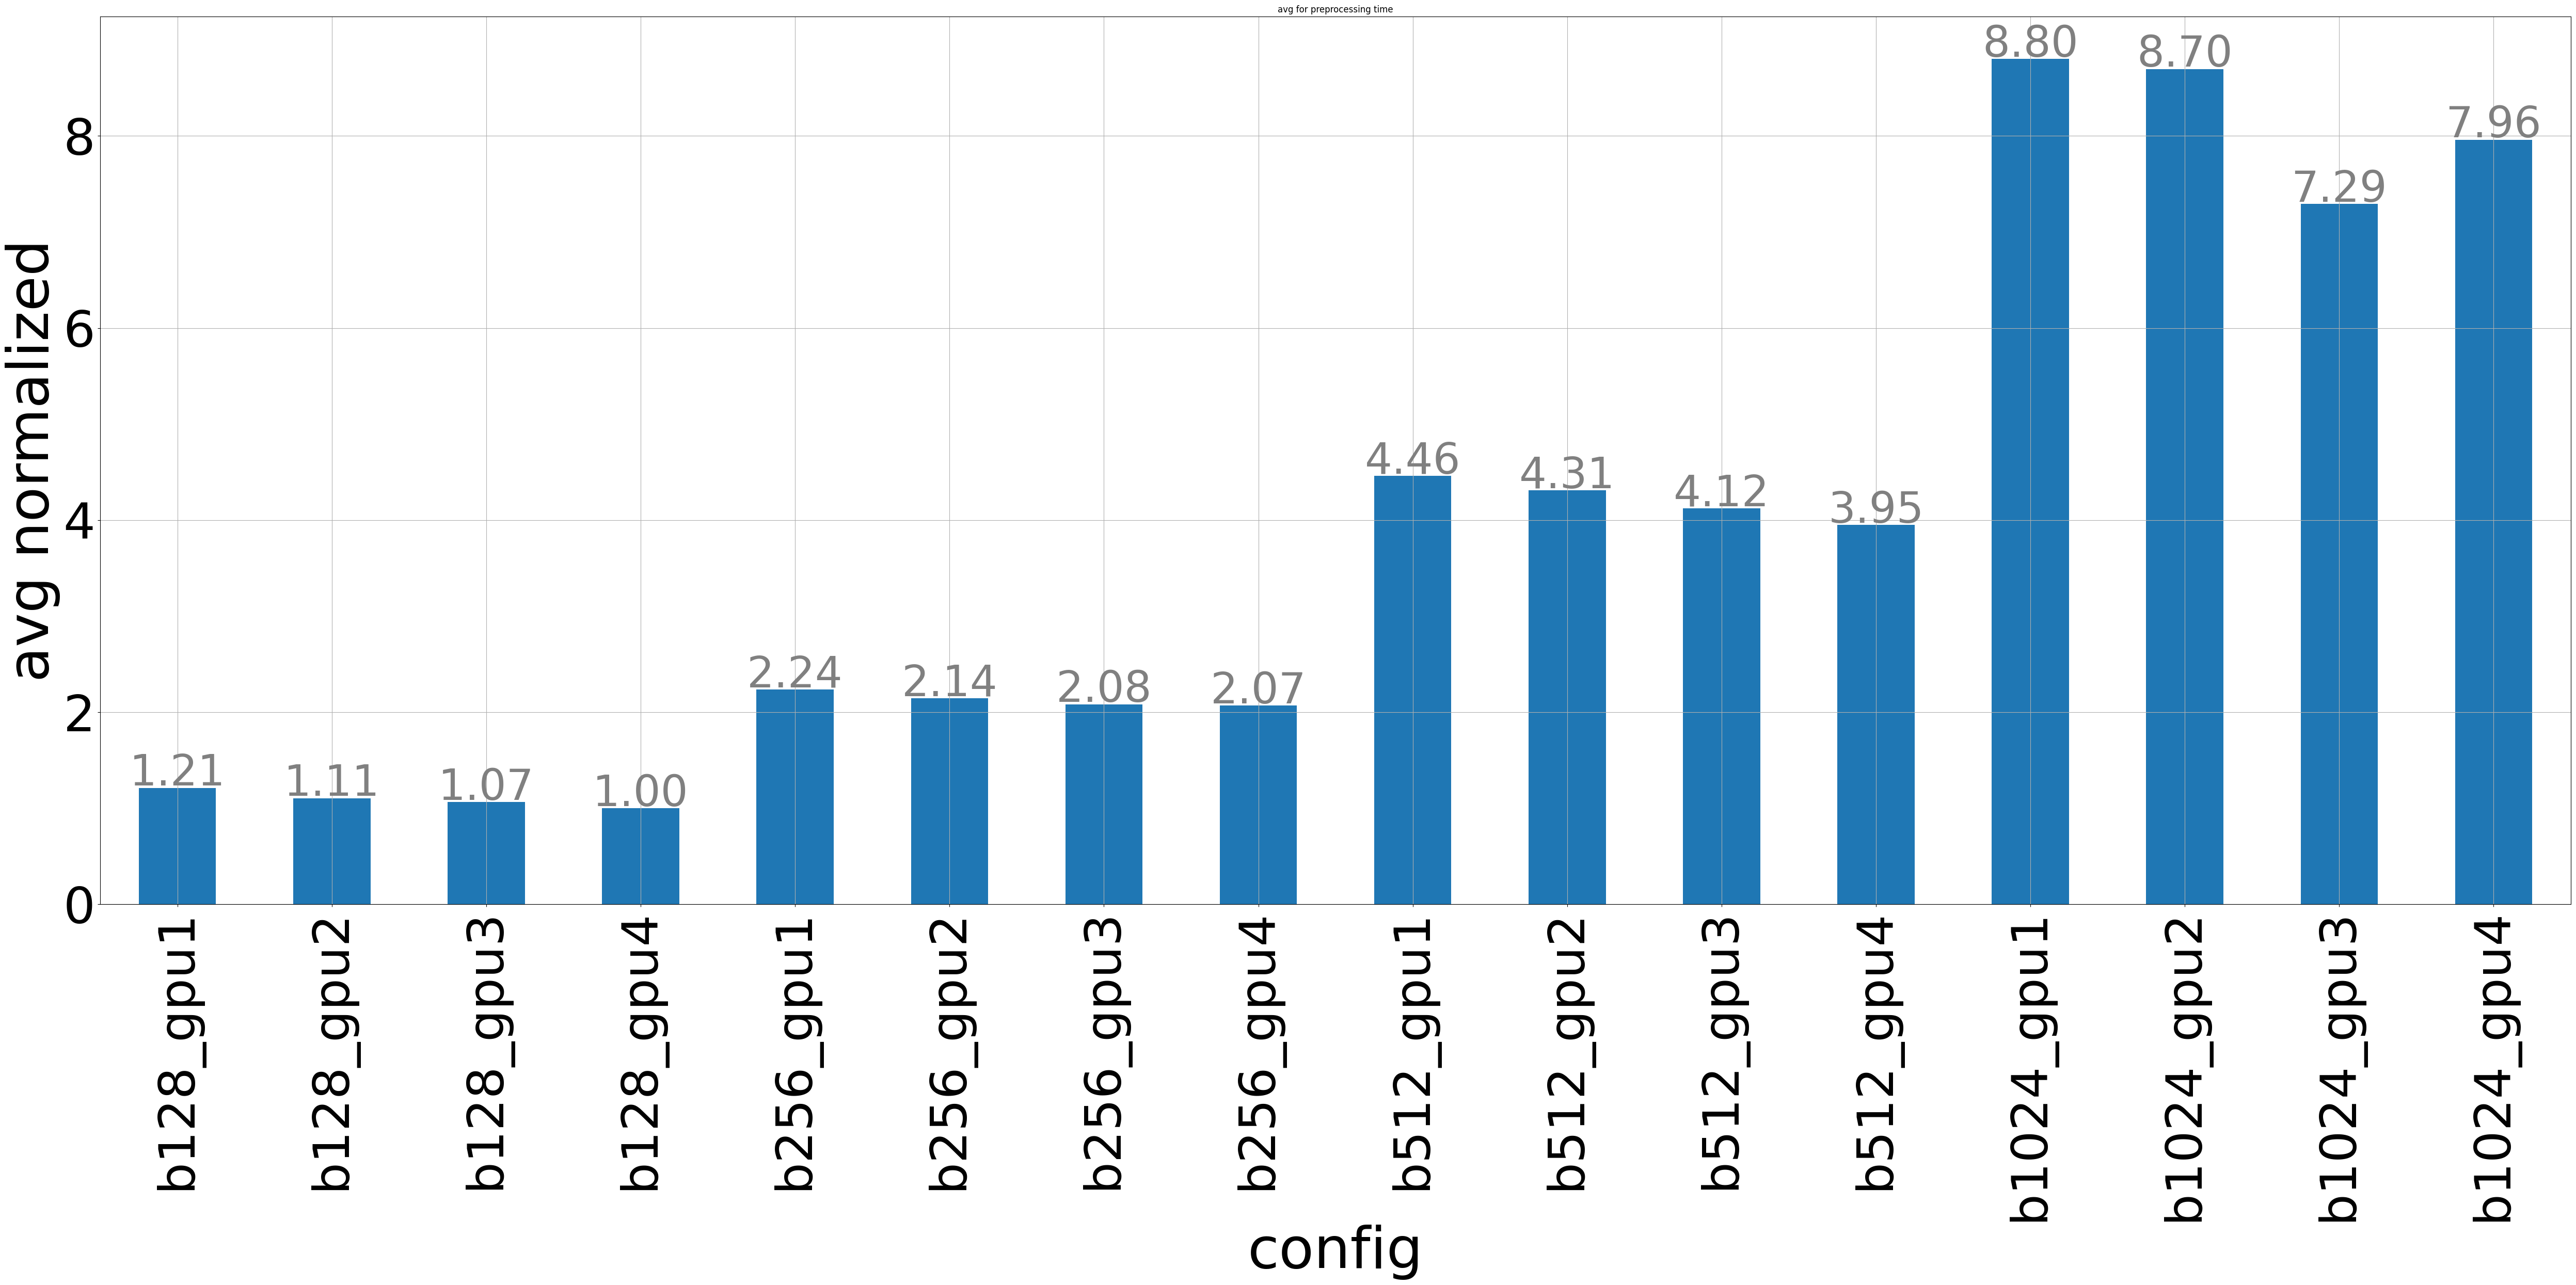

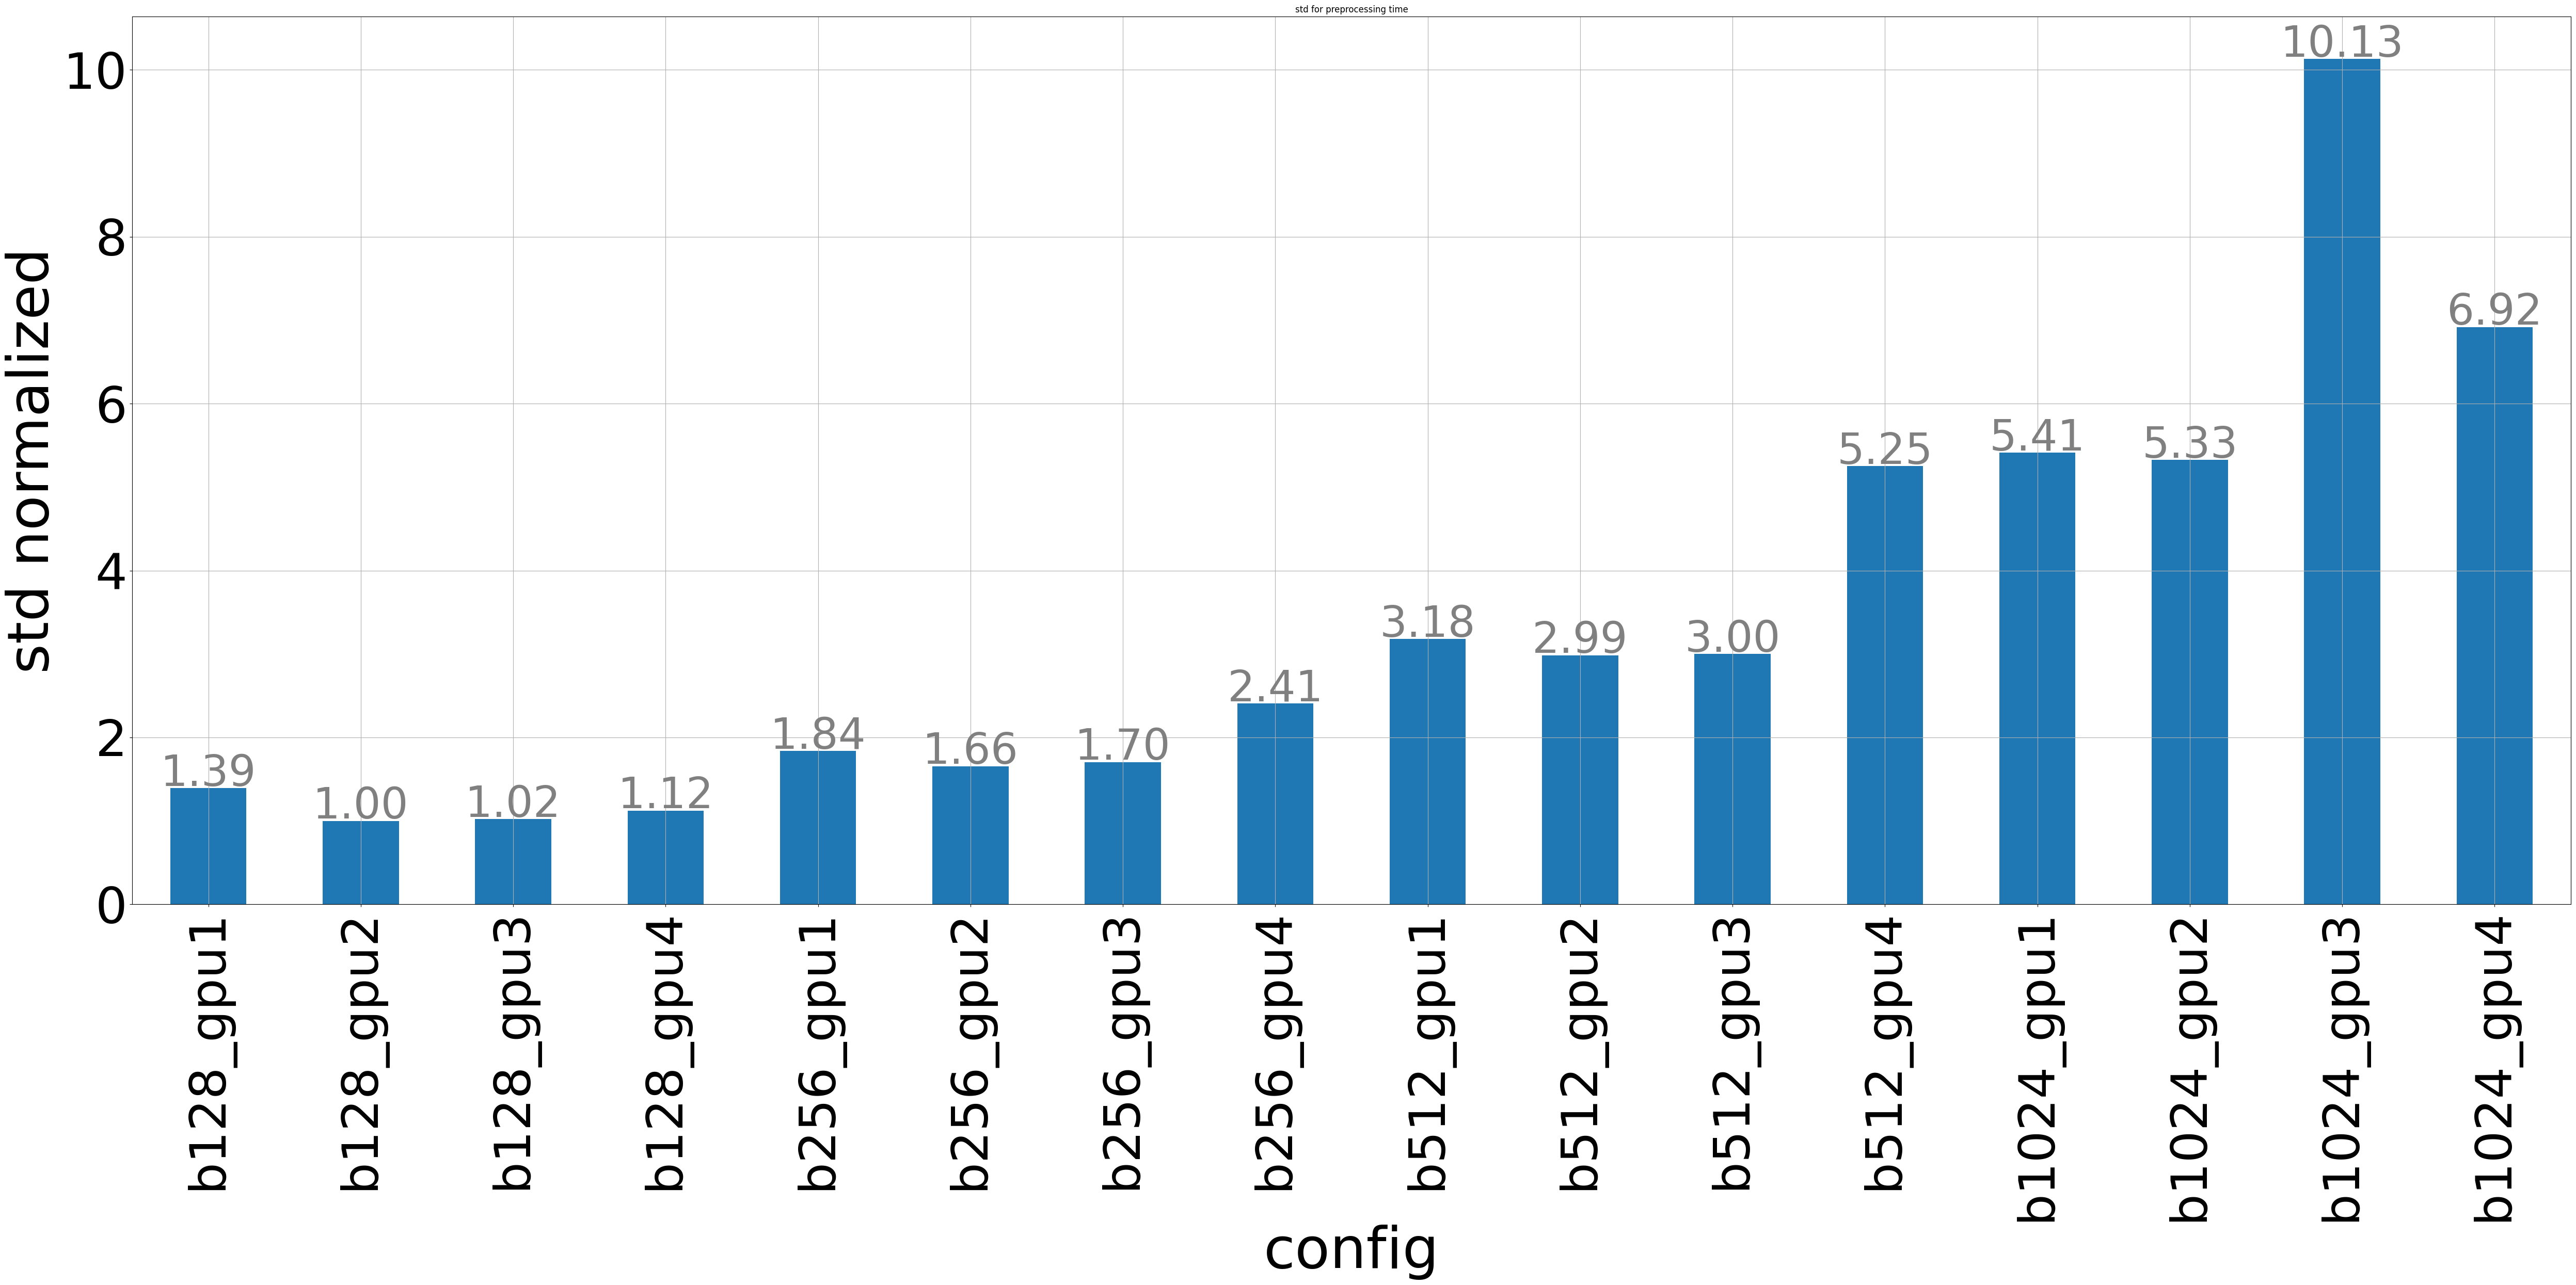

In [13]:
# do the same for avg and std
avg = batch_to_summary['avg']
std = batch_to_summary['std']

avg = pd.DataFrame.from_dict(avg, orient='index', columns=['avg'])
std = pd.DataFrame.from_dict(std, orient='index', columns=['std'])

avg['avg_normalized'] = avg['avg']/avg['avg'].min()
std['std_normalized'] = std['std']/std['std'].min()

fig, ax = plt.subplots(figsize=(50,25))
avg['avg_normalized'].plot(kind='bar', ax=ax)
# put numbers on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=60, color='gray', xytext=(0, 20),
                textcoords='offset points')
    
ax.set_xlabel('config')
ax.set_ylabel('avg normalized')
ax.set_title('avg for preprocessing time')
ax.grid(True)
fig.tight_layout()

plt.show()

fig, ax = plt.subplots(figsize=(50,25))
std['std_normalized'].plot(kind='bar', ax=ax)
# put numbers on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=60, color='gray', xytext=(0, 20),
                textcoords='offset points')
    
ax.set_xlabel('config')
ax.set_ylabel('std normalized')
ax.set_title('std for preprocessing time')
ax.grid(True)
fig.tight_layout()

plt.show()

In [14]:
avg.head(len(avg))

,avg,avg_normalized
b128_gpu1,2812.429454,1.212772
b128_gpu2,2562.587889,1.105036
b128_gpu3,2473.929993,1.066805
b128_gpu4,2319.009006,1.000000
b256_gpu1,5193.675090,2.239610
b256_gpu2,4973.125861,2.144505
b256_gpu3,4832.800995,2.083994
b256_gpu4,4803.695262,2.071443
b512_gpu1,10343.732200,4.460411
b512_gpu2,9993.079124,4.309202


In [15]:
std.head(len(std))

,std,std_normalized
b128_gpu1,422.371882,1.392678
b128_gpu2,303.280411,1.000000
b128_gpu3,310.024110,1.022236
b128_gpu4,340.931420,1.124146
b256_gpu1,556.910206,1.836288
b256_gpu2,502.474174,1.656797
b256_gpu3,517.064965,1.704907
b256_gpu4,730.870632,2.409884
b512_gpu1,963.947276,3.178403
b512_gpu2,905.563087,2.985894


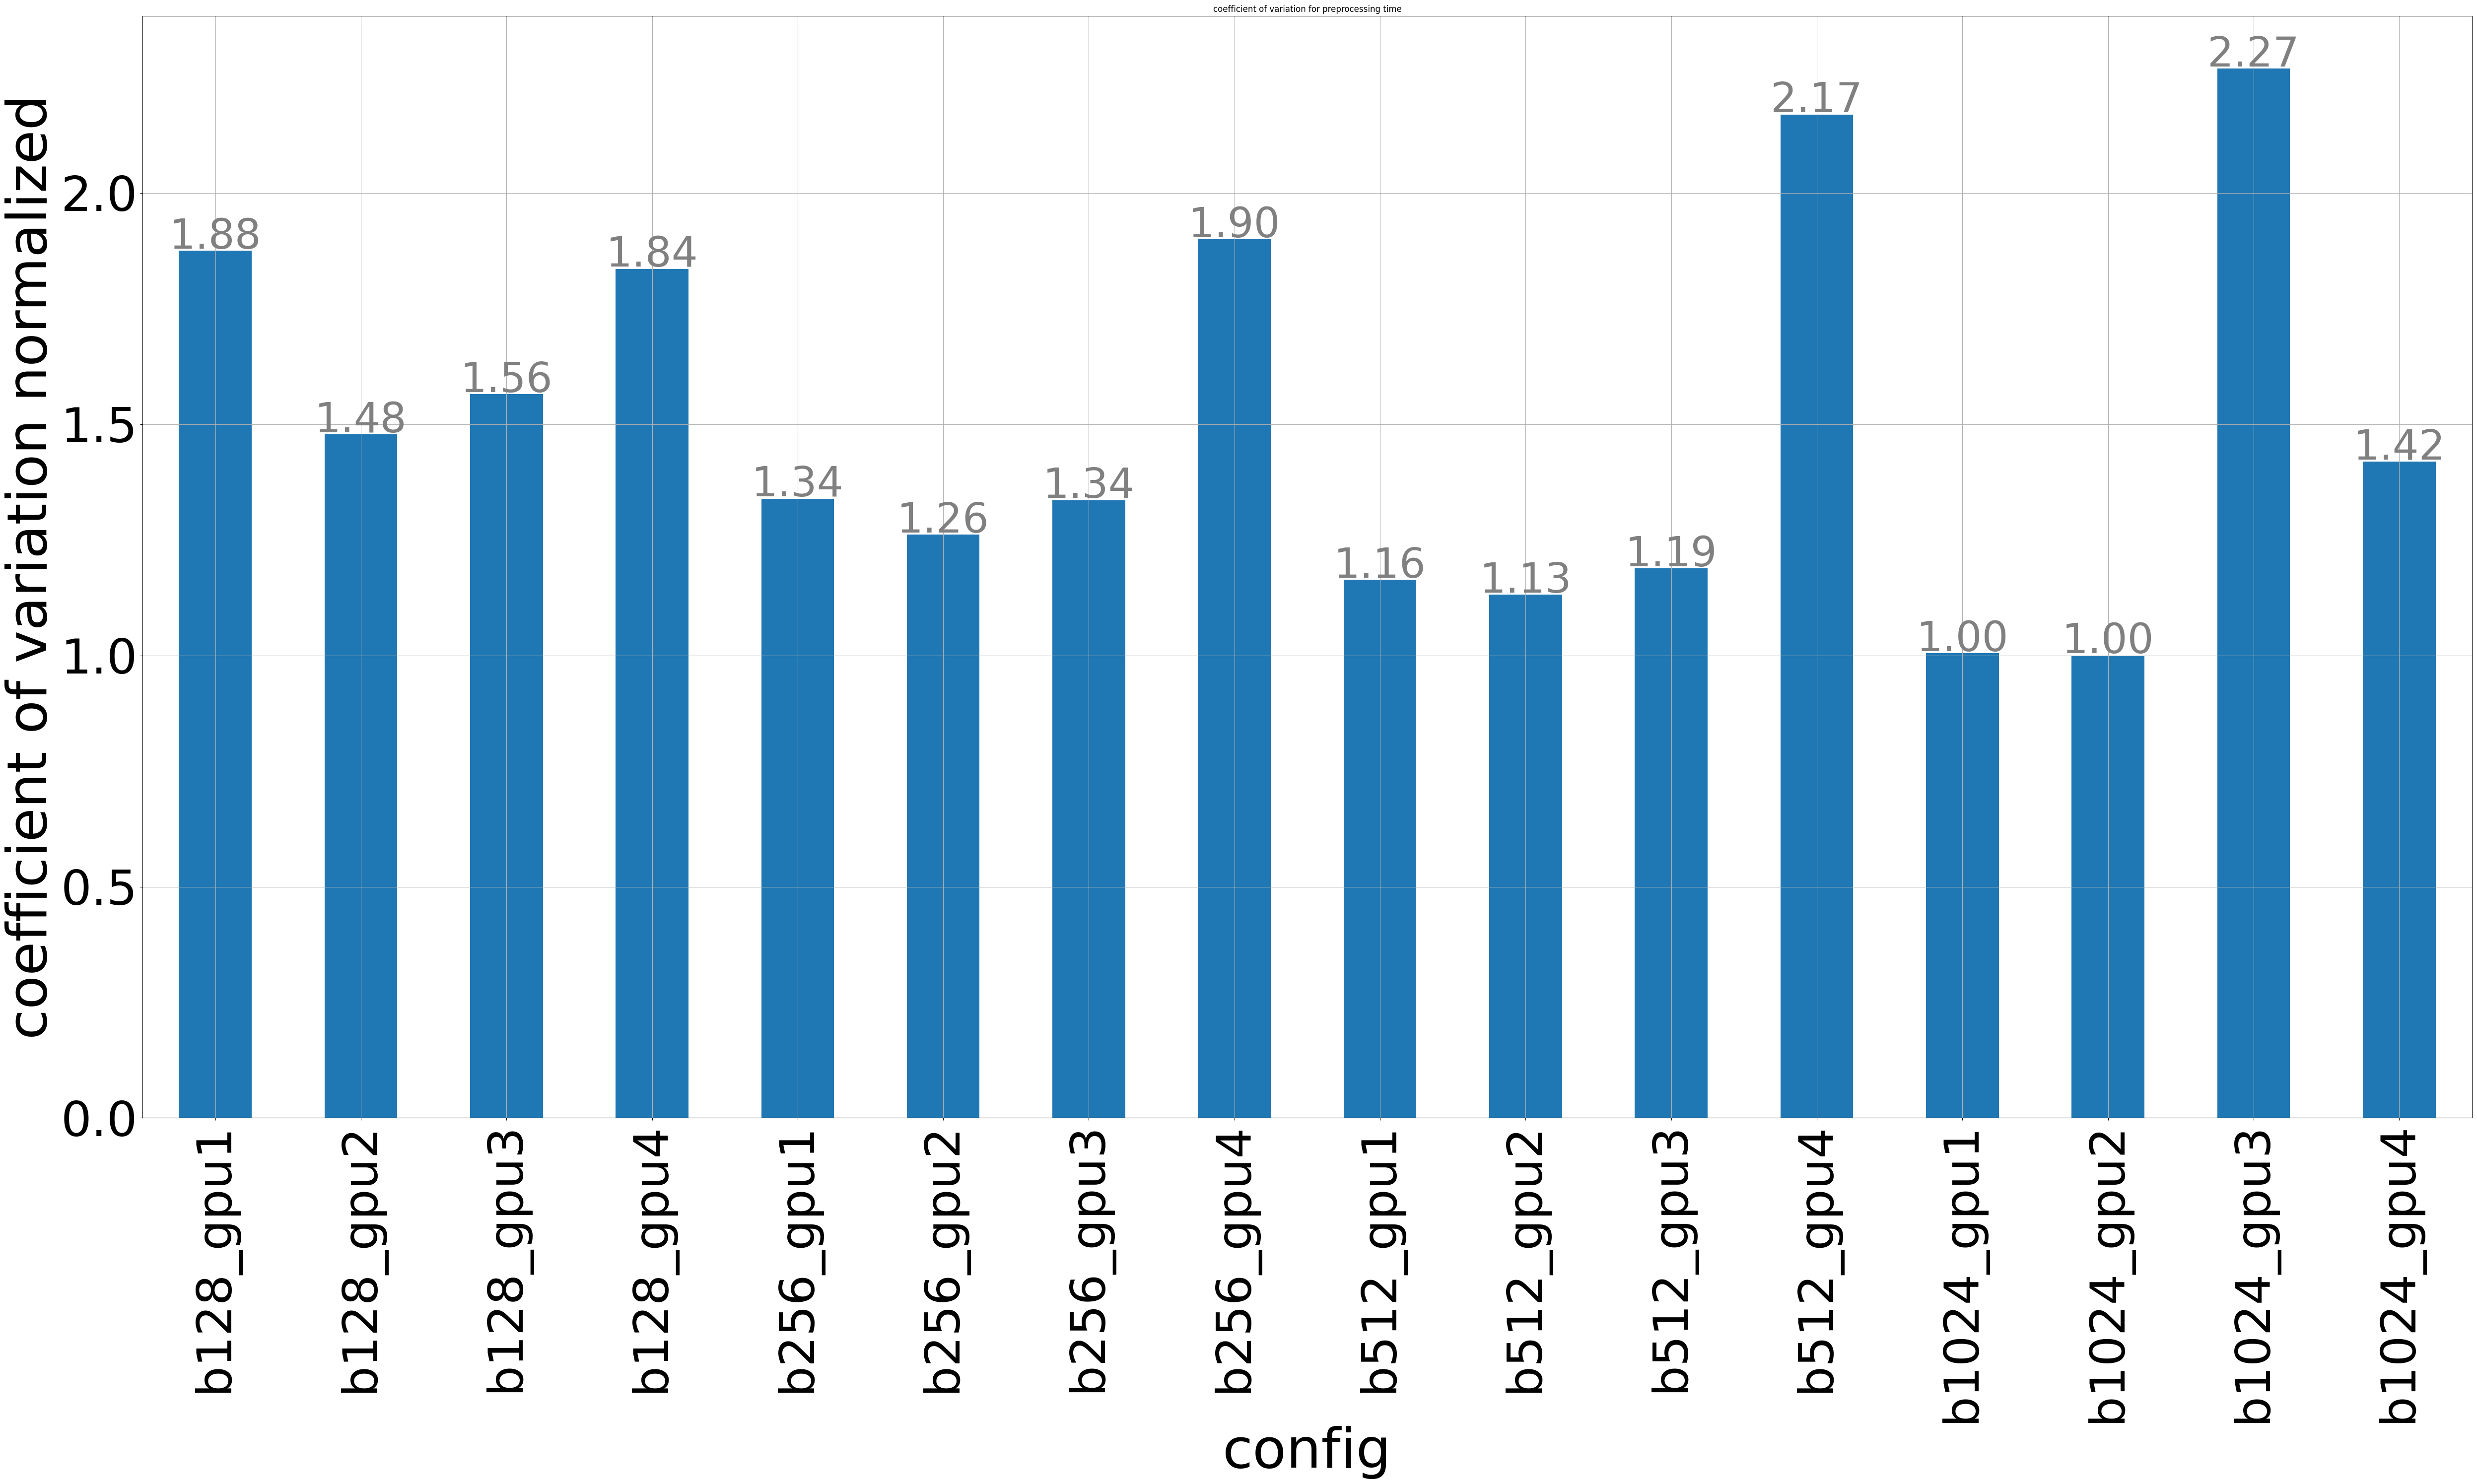

In [16]:
# divide std/avg to get coefficient of variation and normalize it and plot it

coefficient_of_variation = std['std']/avg['avg']

coefficient_of_variation_normalized = coefficient_of_variation/coefficient_of_variation.min()

fig, ax = plt.subplots(figsize=(50,30))
coefficient_of_variation_normalized.plot(kind='bar', ax=ax)
# put numbers on top of bars

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=60, color='gray', xytext=(0, 20),
                textcoords='offset points')
    
ax.set_xlabel('config')
ax.set_ylabel('coefficient of variation normalized')
ax.set_title('coefficient of variation for preprocessing time')
ax.grid(True)
fig.tight_layout()

plt.show()